# Language model from scratch -- RNN

In [1]:
from fastai.text.all import *
path = untar_data(URLs.HUMAN_NUMBERS)

In [2]:
path

Path('/home/jupyter/.fastai/data/human_numbers')

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#2) [Path('valid.txt'),Path('train.txt')]

In [5]:
lines = L()
with open(path/'train.txt') as f: lines += L(*f.readlines())
with open(path/'valid.txt') as f: lines += L(*f.readlines())
lines

(#9998) ['one \n','two \n','three \n','four \n','five \n','six \n','seven \n','eight \n','nine \n','ten \n'...]

In [6]:
lines[-5:]

(#5) ['nine thousand nine hundred ninety five \n','nine thousand nine hundred ninety six \n','nine thousand nine hundred ninety seven \n','nine thousand nine hundred ninety eight \n','nine thousand nine hundred ninety nine \n']

The dataset contains the numbers 1-9999 written out in english.

## Tokenize and numericalize

In [7]:
text = ' . '.join([l.strip() for l in lines])
text[:100]

'one . two . three . four . five . six . seven . eight . nine . ten . eleven . twelve . thirteen . fo'

In [8]:
tokens = L(text.split(' '))
tokens[:10]

(#10) ['one','.','two','.','three','.','four','.','five','.']

In [9]:
tokens[40:50]

(#10) ['twenty','one','.','twenty','two','.','twenty','three','.','twenty']

In [10]:
vocab = L(*tokens).unique()
vocab

(#30) ['one','.','two','three','four','five','six','seven','eight','nine'...]

In [11]:
word2idx = {w:i for i,w in enumerate(vocab)}
nums = L(word2idx[i] for i in tokens)
tokens, nums

((#63095) ['one','.','two','.','three','.','four','.','five','.'...],
 (#63095) [0,1,2,1,3,1,4,1,5,1...])

## A language model 

Let's try and take 3 tokens, and predict the fourth

In [12]:
L((tokens[i:i+3], tokens[i+3]) for i in range(0, len(tokens)-4, 3))

(#21031) [((#3) ['one','.','two'], '.'),((#3) ['.','three','.'], 'four'),((#3) ['four','.','five'], '.'),((#3) ['.','six','.'], 'seven'),((#3) ['seven','.','eight'], '.'),((#3) ['.','nine','.'], 'ten'),((#3) ['ten','.','eleven'], '.'),((#3) ['.','twelve','.'], 'thirteen'),((#3) ['thirteen','.','fourteen'], '.'),((#3) ['.','fifteen','.'], 'sixteen')...]

In [13]:
seqs = L((tensor(nums[i:i+3]), nums[i+3]) for i in range(0, len(nums)-4, 3))

So `seqs` is our complete dataset, with the independent and dependent variables.

`seqs` are legitimate `Datasets` because they have a length and we can index into them.

In [14]:
bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=62, shuffle=False)

In [15]:
x, y = first(dls.train)

In [16]:
x.shape, y.shape

(torch.Size([62, 3]), torch.Size([62]))

### Create a recurrent neural network

In [22]:
class LMModel1(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden) # input -> hidden
        self.h_h = nn.Linear(n_hidden, n_hidden) # hidden -> hidden
        self.h_o = nn.Linear(n_hidden, vocab_sz) # hidden -> output
    
    def forward(self, x):
        h = self.i_h(x[:,0])
        h = F.relu(self.h_h(h))
        h = h + self.i_h(x[:,1])
        h = F.relu(self.h_h(h))
        h = h + self.i_h(x[:,2])
        h = F.relu(self.h_h(h))
        return self.h_o(h)

- First create an embedding for each word in the vocab with `n_hidden` latent variables 

Then, for each word in the mini-batch

1. Pass the 1st embedding through a hidden layer 
1. Pass the embedding through a hidden layer
1. Add the activation to the embedding vector of the second word
1. Pass that through a hidden layer
1. Add the activation to the embedding vector of the third word
1. Pass that through a hidden layer
1. Pass through a final linear layer to reshape the output to `vocab_sz`

The final layer gives us a probability distribution over all words in the vocabulary.

Diagramatically, we can represent the neural net like this:

- input is rectangle
- arrow is a computation
- circle is computed activations
- output is triangle
- Two arrows impinging on a circle is an addition (or concatenation, either is fine -- though it'll change the shape of the hidden layers if you concatenate)


<img src="./figures/rnn.png" width="500">

There is a sublety in the choice of architecture here: we use the **same neural net** `self.h_h` to go from hidden layer to hidden layer. This is because we expect there to be a single rule to transition from word-to-word in the language of human numbers. 

In my own wording, there needs to be a _spatial invariance_ to the model architecture. There should be no special significance to the position of the first, second, or third activations because there is no special significance to the first, second, or third position of the input data. What matters is how you transition between adjacent words/tokens. That's all.

Question: Seems quite limiting in terms of the richness of the model. How do you improve on this...?

In [23]:
learn = Learner(dls, LMModel1(len(vocab), 64), loss_func=F.cross_entropy, metrics=accuracy)

In [24]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.759525,1.980088,0.474210,00:02
1,1.391928,1.788412,0.474447,00:02
2,1.402349,1.661029,0.490611,00:02
3,1.365214,1.630936,0.478013,00:02


Is this any good? A baseline would be to always predict the most common token:

In [25]:
c = Counter(tokens[cut:])
mc = c.most_common(5)
mc

[('thousand', 7104),
 ('.', 7103),
 ('hundred', 6405),
 ('nine', 2440),
 ('eight', 2344)]

In [26]:
mc[0][1]/len(tokens[cut:])

0.15353028894988222

So you only get 15% accuracy when you always predict the token "thousand". We're doing substantially better than that so it is learning something of the structure of the language.

Let's refactor `LMModel1` to use a loop rather than writing out each line. This will have the benefit of allowing us to have token sequences of variable length.

In [27]:
class LMModel2(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden) # input -> hidden
        self.h_h = nn.Linear(n_hidden, n_hidden) # hidden -> hidden
        self.h_o = nn.Linear(n_hidden, vocab_sz) # hidden -> output
    
    def forward(self, x):
        h = 0.  
        for i in range(3):
            h += self.i_h(x[:,i])
            h = F.relu(self.h_h(h))                    
        return self.h_o(h)

This model is a bona-fide **recurrent neural network**. 

In [28]:
learn = Learner(dls, LMModel2(len(vocab), 64), loss_func=F.cross_entropy, 
                metrics=accuracy)
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.850702,1.989384,0.466128,00:02
1,1.421135,1.794140,0.468267,00:02
2,1.423546,1.665611,0.493463,00:02
3,1.381168,1.674273,0.444260,00:02


Which can be depicted graphically as:

<img src="./figures/rnn-ravel.png" width="500">

## Maintaining the state of an RNN

In `LMModel2`, we initialize the hidden state as `h = 0.`, which means that everything learnt up to that point is forgotten. But we're learning the full string of numbers from 0-9999, so it doesn't make much sense to throw away the state every time we get a new token sequence because there exists logical continuity between sequences.

We can achieve this simply by having the hidden state as an attribute of the model class.

In [30]:
class LMModel3(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = 0.
    
    def forward(self, x):
        for i in range(3):
            self.h += self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
        out = self.h_o(self.h)  # we only want to retain the hidden state
        self.h = self.h.detach() # throw away gradient history     
        return out  # we only want to return the output
    
    def reset(self): self.h = 0.

We need `self.h.detach()` because, without it, we'll be calculating the gradient of the loss with respect to `self.h` through _all previous mini-batches_. Whilst this is conceptually ok, computationally it's a bad idea -- it'll get very slow, take up a huge amount of memory, and potentially introduce a lot of instability due to the exploding gradients problem (or have no effect for all the work we've done, due to the vanishing gradients problem).

We use `self.h.detach()` to throw away gradient history. 

- _Backpropagation through time (BPTT)_: Retaining the state between batches, but only having **a single hidden layer** per time step. 
- _Truncated BPTT_: Detaching the history of the computation of steps in the hidden state every few time steps.

We need to make sure that the samples are seen in the correct order so that the text flows properly through the model. `LMDataLoader` did this for us in the previous notebook but we'll do it ourselves here.

In [35]:
m = len(seqs)//bs
m, bs, len(seqs)

(328, 64, 21031)

The first batch should be composed of samples

```
(0, m, 2*m, ..., (bs-1)*m)
```

(where this vector is of length `bs`). The second batch should be composed of

```
(1, m+1, 2*m+1, ..., (bs-1)*m+1)
```

and so on `m` times. In this way, at each epoch, the model will see contiguous chunks of text of size `3*m` (since each token sequence consists of 3 tokens).


_**Note to self**_: Doesn't seem totally clear to me. What exactly is being done in parallel? At each mini-batch, 64 gradients are computed for the same model. These 64 gradients have nothing to do with each other. At this point, are the model parameters updated sequentially 64 times? Or is this stored in a computational tree, and only at the end of the epoch are the gradients for the model actually updated? That seems to be the implication of what they're saying, otherwise all this reshaping and batch assignment doesn't make any sense...

The following function does the reindexing:

In [36]:
def group_chunks(ds, bs):
    m = len(ds) // bs
    new_ds = L()
    for i in range(m): new_ds += L(ds[i + m*j] for j in range(bs))
    return new_ds

We then drop the last batch which doesn't have the right shape, and do not shuffle the text to ensure text is read in order.

In [38]:
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut], bs),
    group_chunks(seqs[cut:], bs),
    bs=bs,
    drop_last=True,
    shuffle=False
)

At the start of each epoch we need to call `LMModel3.reset()`, because at the start of each epoch we are going back to the start of the natural numbers. So that means the activations `self.h` need to be reset.

We also need to reset the activations when we perform validation.

We can achieve this vai a `Callback` which say, during the training loop, train some particular code. We'll use `ModelResetter` which calls `model.reset` at

- The beginning of training
- The beginning of validation
- After fitting

In [39]:
learn = Learner(dls, LMModel3(len(vocab), 64), loss_func=F.cross_entropy,
                metrics=accuracy, cbs=ModelResetter
               )
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.721246,1.878376,0.395673,00:02
1,1.302078,1.694434,0.494952,00:02
2,1.119961,1.510426,0.519471,00:01
3,1.040456,1.578070,0.528846,00:02
4,0.992497,1.591788,0.549038,00:02
5,0.944943,1.618226,0.556250,00:02
6,0.884938,1.551036,0.582452,00:02
7,0.843339,1.621597,0.584135,00:02
8,0.812761,1.617809,0.601202,00:02
9,0.797448,1.622385,0.602644,00:02


This is a **stateful RNN**, which is much better.

## Creating more signal

Another problem with our current approach is that we only predict one output word for each 3 input words, which is quite wasteful. The amount of signal we feed back to update weights is not as large as it could be. It would be better to predict the next word after every single word, rather than every three words.

<img src="./figures/rnn-signal.png" width=500>

So, after every single state is created, do a prediction. Then our prediction will be the entire set of numbers, offset by 1.

To do this, need to change our data such that each of the next 3 words are present for each of the 3 inputs.

Let's change the sequence length (`sl`) from 3 to 16.

In [42]:
sl=5

In [43]:
L((tokens[i:i+sl], tokens[i+1:i+sl+1])
         for i in range(0, len(nums)-sl-1, sl)
        )

(#12618) [((#5) ['one','.','two','.','three'], (#5) ['.','two','.','three','.']),((#5) ['.','four','.','five','.'], (#5) ['four','.','five','.','six']),((#5) ['six','.','seven','.','eight'], (#5) ['.','seven','.','eight','.']),((#5) ['.','nine','.','ten','.'], (#5) ['nine','.','ten','.','eleven']),((#5) ['eleven','.','twelve','.','thirteen'], (#5) ['.','twelve','.','thirteen','.']),((#5) ['.','fourteen','.','fifteen','.'], (#5) ['fourteen','.','fifteen','.','sixteen']),((#5) ['sixteen','.','seventeen','.','eighteen'], (#5) ['.','seventeen','.','eighteen','.']),((#5) ['.','nineteen','.','twenty','.'], (#5) ['nineteen','.','twenty','.','twenty']),((#5) ['twenty','one','.','twenty','two'], (#5) ['one','.','twenty','two','.']),((#5) ['.','twenty','three','.','twenty'], (#5) ['twenty','three','.','twenty','four'])...]

In [45]:
sl = 16
seqs = L((tensor(nums[i:i+sl]), tensor(nums[i+1:i+sl+1]))
         for i in range(0, len(nums)-sl-1, sl)
        )
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(group_chunks(seqs[:cut], bs),
                             group_chunks(seqs[cut:], bs),
                             bs=bs,
                             drop_last=True,
                             shuffle=False
                            )

In [46]:
[L(vocab[o] for o in s) for s in seqs[0]]

[(#16) ['one','.','two','.','three','.','four','.','five','.'...],
 (#16) ['.','two','.','three','.','four','.','five','.','six'...]]

Now we just need to modify the model so that it outputs a prediction after every token, rathen than just at the end of a three-token sequence:

In [56]:
class LMModel4(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = 0.
    
    def forward(self, x):
        outs = []
        for i in range(sl):
            self.h = self.h + self.i_h(x[:,i])  # weird: += seems to confuse pytorch
            self.h = F.relu(self.h_h(self.h))
            outs.append(self.h_o(self.h)) # output for every token
        self.h = self.h.detach() 
        return torch.stack(outs, dim=1) 
    
    def reset(self): self.h = 0.

This model returns outputs of shape `bs x sl x vocab_sz` (since we stacked on dimension 1). 

Our targets are of shape `bs x sl`. So we need to flatten those before using them in `F.cross_entropy`:

In [57]:
def loss_func(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))

(Not sure about the `.view` details here)

And now we can train

In [62]:
learn = Learner(dls, LMModel4(len(vocab), 64), loss_func=loss_func,
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(30, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.227117,3.160564,0.157959,00:00
1,2.776564,2.437939,0.388021,00:00
2,2.064298,1.950222,0.468913,00:00
3,1.675839,1.794347,0.474609,00:00
4,1.457691,1.874112,0.479167,00:00
5,1.322245,1.743223,0.503255,00:00
6,1.203618,1.860203,0.497152,00:00
7,1.125153,1.816316,0.531982,00:00
8,1.053785,1.796995,0.528971,00:00
9,0.973118,2.010507,0.557292,00:00


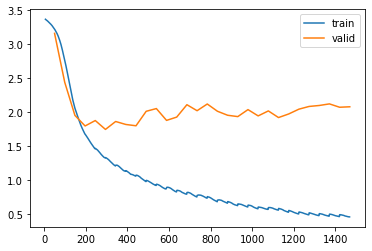

In [63]:
learn.recorder.plot_loss()

In [75]:
learn.fit_one_cycle(30, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.452704,2.109696,0.576335,00:01
1,0.463176,2.080742,0.576416,00:00
2,0.498154,2.062097,0.548096,00:00
3,0.511734,1.962567,0.610840,00:00
4,0.521158,2.204545,0.616618,00:00
5,0.529827,2.088227,0.602620,00:00
6,0.510220,1.900282,0.551188,00:00
7,0.489046,2.067856,0.589925,00:00
8,0.491480,2.287981,0.540609,00:00
9,0.458506,2.131739,0.588786,00:00


Results are quite variable because we have a very deep neural network here, resulting in unstable gradients.

And yet we've only got one hidden layer, so the model can't do very sophisticated computations. The obvious thing to do is try having more layers.

## Multilayer RNNs

Would look something like this:

<img src="./figures/rnn-multi.png" width="700">

The dotted arrows are different weight matrices to the solid arrows.

Use `nn.RNN` which is the same as `LMModel4` but lets us stack models conveniently ontop of each other.

In [77]:
class LMModel5(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first=True)        
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers, bs, n_hidden)
    
    def forward(self, x):
        res, h = self.rnn(self.i_h(x), self.h)        
        self.h = h.detach() 
        return self.h_o(res)
    
    def reset(self): self.h.zero_()

In [79]:
learn = Learner(dls, LMModel5(len(vocab), 64, 2),
                loss_func=CrossEntropyLossFlat(),
               metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.110875,2.665747,0.461670,00:01
1,2.174251,1.802367,0.471842,00:00
2,1.715677,1.908851,0.313314,00:01
3,1.498473,1.800743,0.454834,00:00
4,1.351316,1.773410,0.479085,00:01
5,1.242161,1.853326,0.498210,00:00
6,1.158545,2.038881,0.504150,00:00
7,1.081536,2.106154,0.503988,00:00
8,1.013214,2.225335,0.502034,00:00
9,0.955277,2.259951,0.506022,00:00


Performance isn't so good. Deep model means exploding/disappearing gradients. We can get around this with LSTMs.

## LSTMs

Consists of cells containing mini neural networks, deciding how much of the previous state to keep/forget, how much of the input to keep, and how much of the "cell state" to keep/forget, which is a state which can zip straight through the network with few perturbations, so that long-term patterns can be learnt.

I won't build this from scratch for now, though the fastai book has this. We can just replace `nn.RNN` with `nn.LSTM`.

In [88]:
class LMModel6(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)        
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
    
    def forward(self, x):
        res, h = self.rnn(self.i_h(x), self.h)        
        self.h = [h_.detach()  for h_ in h]
        return self.h_o(res)
    
    def reset(self): 
        for h in self.h: h.zero_()

In [89]:
learn = Learner(dls, LMModel6(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.011936,2.767241,0.265544,00:01
1,2.232252,1.753886,0.455322,00:01
2,1.641269,2.023682,0.465902,00:01
3,1.387783,1.865891,0.506592,00:01
4,1.204617,2.271569,0.513753,00:01
5,0.997613,1.915654,0.601807,00:01
6,0.736215,1.439248,0.657389,00:01
7,0.505693,1.411785,0.689616,00:01
8,0.335138,1.361626,0.710286,00:01
9,0.212083,1.436214,0.734375,00:01


Much better. Overfitting a bit, let's use some regularization.

## Regularizing an LSTM

### Dropout

Dropout is particularly effective for RNNs. Dropout is simply zeroing the activations during training with probability `p`. To retain the scale of the output after zeroing activations with probability `p`, we rescale all activations by dividing them by `1-p`). At test time, all the activations are present, and they are left alone. You can also do it the other way around, like the image below.

<img src="./figures/dropout.png" width="500">

### Activation regularization (AR) and temporal activation regularization (TAR)

We can also explicitly penalize the activations from becoming too large by adding a regularization term to the _activations_ in the loss function (AR)

```python
loss += alpha * activations.pow(2).mean()
```

We can also penalize the activations changing rapidly between time steps (TAR)

```python
loss += beta * (activations[:,1:] - activations[:,:-1]).pow(2).mean()
```

### Weight-tied regularization

In the above model:

- Input embedding = Conversion of token -> activation
- Output hidden layer = Conversion from activation -> token

Apparently, it is intuitive to think that these activations are the same (though in my mind it's more intuitive that they are encoding/decoding steps, so there's no reason they should be the same).

Anyway, we can enforce this with

```python
self.h_o.weight = self.i_h.weight
```

In [99]:
class LMModel7(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight # weight tying. The two objects will always be identical
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(out),raw,out
    
    def reset(self): 
        for h in self.h: h.zero_()

In [100]:
learn = Learner(dls, LMModel7(len(vocab), 64, 2, 0.5),
                loss_func=CrossEntropyLossFlat(), metrics=accuracy,
                cbs=[ModelResetter, RNNRegularizer(alpha=2, beta=1)])

Or, more simply,

In [101]:
learn = TextLearner(dls, LMModel7(len(vocab), 64, 2, 0.4),
                    loss_func=CrossEntropyLossFlat(), metrics=accuracy)

And add weight decay for good measure

In [102]:
learn.fit_one_cycle(15, 1e-2, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,2.597233,1.856889,0.481934,00:01
1,1.674434,1.300253,0.626872,00:01
2,0.997507,0.898619,0.744059,00:01
3,0.564185,0.707201,0.791504,00:01
4,0.355193,0.548807,0.834880,00:01
5,0.250618,0.543925,0.840251,00:01
6,0.198203,0.488984,0.856934,00:01
7,0.164151,0.432972,0.875407,00:01
8,0.143137,0.387605,0.888997,00:01
9,0.130521,0.427740,0.878011,00:01


This is now all of the pieces for a AWD-LSTM.